# Programming Assignment 3 - Logistic regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

**NOTE**: The original assignment used a dataset from Dr. DeGiorgio's work. The public version of the notebook uses the [glass dataset](https://archive.ics.uci.edu/ml/datasets/Glass+Identification). Logistic regression doesn't perform well on this dataset (even scikit-learn with cross-validation achieves about 60% accuracy). However, it is a good example of a multi-label dataset.

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
from typing import Tuple
import numpy as np
import pandas as pd

# Import and set up the graphing environment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots legible and focus on trends (not specific values)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine();

# Improve table formatting
pd.options.display.float_format = '{:,.2f}'.format

# Show all rows when displaying tables
# Helps fir in page row when exporting to PDF
pd.set_option('display.max_rows', None)

# Make experiments more reproducible
np.random.seed(42)

<Figure size 432x288 with 0 Axes>

Import our logistic regression module and the utilities.

In [2]:
import utils
import logistic

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the experiments.

In [3]:
import sys
sys.path.append('./test')
import test_logistic
# Set to true to see each test result
test_logistic.test_all(False, './data')
print('All tests passed')

All tests passed


Constants used in the experiments.

In [4]:
LAMBDAS_TO_TEST = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
NUM_TESTS = len(LAMBDAS_TO_TEST)
LR = 0.00001
ITERATIONS = 10_000
NUM_FOLDS = 5

# Note: hard-coded for simplification - must match the classifier
CLASS_NAMES = ['building_windows_float_processed', 'building_windows_non_float_processed', 'containers',
               'headlamps', 'tableware', 'vehicle_windows_float_processed']
# Shorter names for better-lloking tables when exported to PDF
CLASS_NAMES_SHORT = ['WFLT', 'WNFLT', 'CNT', 'HDL', 'TBW', 'VFLT']

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [5]:
TRAINING_DATASET = 'training'
TEST_DATASET = 'test'
FEATURE_NAMES = []

def read_dataset(train_test: str,
    standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:

    global FEATURE_NAMES, CLASS_NAMES

    if train_test == TRAINING_DATASET:
        file = './data/glass_train.csv'
    else:
        file = './data/glass_test.csv'

    # Shuffling is needed for training only
    shuffle = train_test == TRAINING_DATASET
        
    x, y, y_raw, FEATURE_NAMES, classes = utils.read_dataset(file,
        hot_encode=True, shuffle=shuffle)
    
    if standardize:
        utils.scale(x)
        # Note that y is not centered in this case

    return x, y, y_raw

# Deliverable 1 - effect of lambda on coefficients

> _Illustrate the effect of the tuning parameter on the inferred ridge regression coefficients by generating one plot for each class of none lines (one for each of the p = 9 features), with the y-axis as β̂jk, j = 1,2, ... ,9 for the graph of class k, and x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular β̂jk._

Perform logistic regression with the different lambda values (takes several seconds to complete).

In [6]:
betas = []
for lmbda in LAMBDAS_TO_TEST:
    x, y, _ = read_dataset(TRAINING_DATASET)
    b = logistic.fit(x, y, lr=LR, lmbda=lmbda, iterations=ITERATIONS)
    # Remove beta0, store only the betas for the classes
    betas.append(b[1:, :])

Plot the coefficient for each class side by side to compare them (Y axis scale is the same for all graphs).

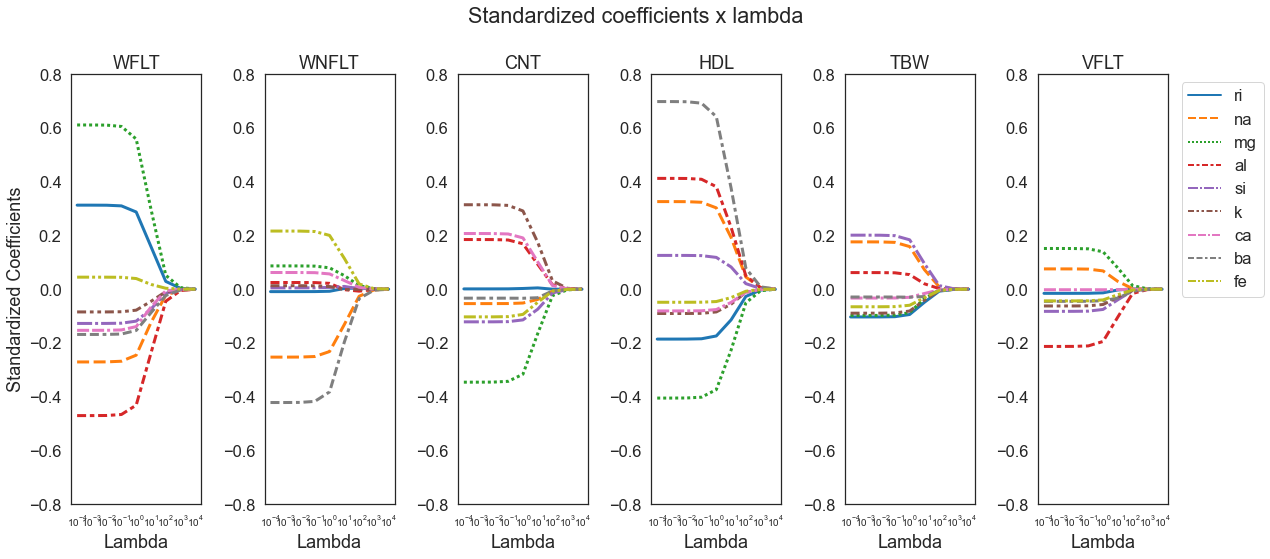

In [7]:
def plot_betas(betas, title, max_y, min_y):
    # Prepare a dataframe in the long format to plot
    df_plot = pd.DataFrame()
    for i, lmbda in enumerate (LAMBDAS_TO_TEST):
        dfx = pd.DataFrame(np.squeeze(betas[i]), columns=CLASS_NAMES, 
                           index=[FEATURE_NAMES, [lmbda]*len(FEATURE_NAMES)])
        df_plot = df_plot.append(dfx)
        dfx_plot = dfx.stack().reset_index()
    df_plot = df_plot.stack().reset_index()
    df_plot.columns = ['Feature', 'Lambda', 'Cls', 'Standardized Coefficients']

    # Plot each class side-by-side, with the same Y axis scale for comparison
    num_classes = len(CLASS_NAMES)
    fig, ax = plt.subplots(1, num_classes, figsize=(18, 8))
    for i, cls in enumerate(CLASS_NAMES):
        sns.lineplot(ax=ax[i], y='Standardized Coefficients', x='Lambda',
                     data=df_plot[df_plot.Cls == cls],
                     hue='Feature', style='Feature', linewidth=3,
                     legend=i == num_classes-1)
        ax[i].set_title(CLASS_NAMES_SHORT[i])

        # Improve y axis: show only once to save space, use the same scale
        ax[i].axes.set_ylabel('Standardized Coefficients' if i == 0 else '')
        ax[i].set_ylim(min_y, max_y)

        # Improve x axis: log scale, show all tick values (with smaller font)
        ax[i].set_xscale('log')
        ax[i].set_xticks(LAMBDAS_TO_TEST)
        ax[i].tick_params(axis='x', which='major', labelsize=10)
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    fig.suptitle(title)
    plt.tight_layout()
    
plot_betas(betas, 'Standardized coefficients x lambda', 0.8, -0.8)

# Deliverable 2 - effect of lambda on cross-validation error (categorial cross-entropy)

> _Illustrate the effect of the tuning parameter on the cross validation error by generating a plot with the y-axis as CV(5) error, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular CV(5) error._

Perform logistic regression with the different lambda values and cross validation (takes several seconds to complete).

In [8]:
cce = np.zeros(NUM_TESTS)
for i, lmbda in enumerate(LAMBDAS_TO_TEST):
    x, y, _ = read_dataset(TRAINING_DATASET, standardize=False)
    fold_cce = np.zeros(NUM_FOLDS)
    for fold in range(1, NUM_FOLDS+1, 1):
        x_train, x_val, y_train, y_val = utils.split_fold(x, y,
                                                          num_folds=NUM_FOLDS,
                                                          fold=fold)
        utils.scale_val(x_train, x_val)
        model = logistic.fit(x_train, y_train, lr=LR, lmbda=lmbda, iterations=ITERATIONS)
        probabilities, _ = logistic.predict(x_val, model)
        fold_cce[fold-1] = logistic.categorical_cross_entropy(y_val, probabilities)
    cce[i] = fold_cce.mean()

Plot the results.

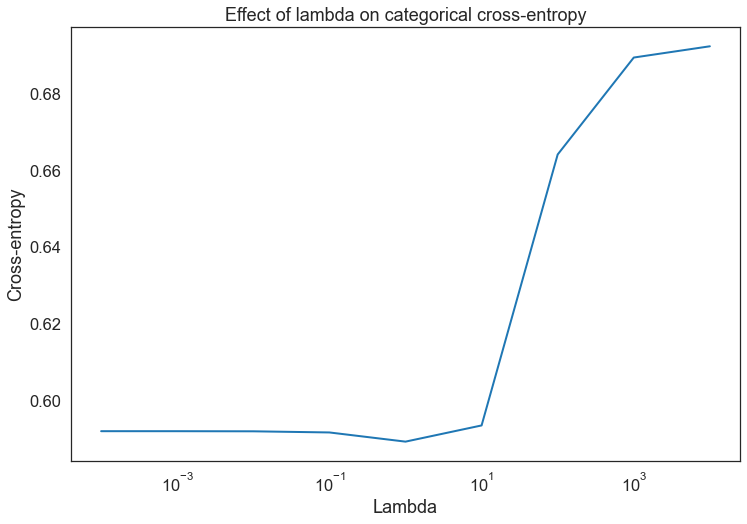

In [9]:
def plot_cce(cce: np.ndarray, title: str):
    # Create a DataFrame in the long format to plot
    df2 = pd.DataFrame([LAMBDAS_TO_TEST, cce]).T
    df2.columns = ['Lambda', 'Cross-entropy']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    sns.lineplot(ax=ax, y='Cross-entropy', x='Lambda', data=df2)
    ax.set_xscale('log')
    ax.set_title(title)

plot_cce(cce, 'Effect of lambda on categorical cross-entropy')

# Deliverable 3 - the lambda with the smallest cross-validation error

> _Indicate the value of λ value (sic) that generated the smallest CV(5) error._

In [10]:
smallest_cce_index = np.nanargmin(cce)
smallest_cce_lambda = LAMBDAS_TO_TEST[smallest_cce_index]
print(f'The lambda with the smallest categorical cross-entropy is {smallest_cce_lambda}')

The lambda with the smallest categorical cross-entropy is 1.0


# Deliverable 4 - model parameters for the lambda with the smallest cross-validation error

> _Given the optimal λ, retrain your model on the entire dataset to obtain an estimate of the (p + 1) × K model parameter matrix as B̂ and make predictions of the probability for each of the classes for all instances in test dataset._

> Report all probabilities for each of the classes and the most probable label for all test instances.

Train a model with the lambda that resulted in the smallest categorical cross-entropy.

In [11]:
x, y, y_raw = read_dataset(TRAINING_DATASET)
betas4 = logistic.fit(x, y, lr=LR, lmbda=smallest_cce_lambda, iterations=ITERATIONS)

Predict the values on the test set.

In [12]:
x_test, y_test, y_test_raw = read_dataset(TEST_DATASET)
probabilities4, classes4 = logistic.predict(x_test, betas4)

Show probabilities and predicted vs. actual class for the test set.

In [13]:
# Class names from class numbers
dfclass = pd.DataFrame([CLASS_NAMES[int(x)] for x in classes4], columns=['Predicted'])
dfclass.index = np.arange(1, len(dfclass) + 1)
# Probabilities for each class
dfprob = pd.DataFrame(probabilities4, columns=CLASS_NAMES_SHORT)
dfprob.index = np.arange(1, len(dfprob) + 1)
# The actual label column from the test set
dfactual = pd.DataFrame(y_test_raw, columns=['Actual'])
dfactual.index = np.arange(1, len(dfactual) + 1)

# Combine them
dfcombined = pd.concat([dfprob, dfclass, dfactual], axis=1)

dfcombined

,WFLT,WNFLT,CNT,HDL,TBW,VFLT,Predicted,Actual
1,0.54,0.27,0.04,0.02,0.04,0.09,building_windows_float_processed,building_windows_float_processed
2,0.35,0.38,0.05,0.05,0.07,0.09,building_windows_non_float_processed,building_windows_float_processed
3,0.38,0.27,0.06,0.06,0.10,0.12,building_windows_float_processed,building_windows_float_processed
4,0.25,0.47,0.06,0.07,0.07,0.08,building_windows_non_float_processed,building_windows_float_processed
5,0.41,0.30,0.07,0.04,0.08,0.11,building_windows_float_processed,building_windows_float_processed
6,0.38,0.26,0.06,0.07,0.10,0.13,building_windows_float_processed,building_windows_float_processed
7,0.36,0.32,0.08,0.06,0.08,0.11,building_windows_float_processed,building_windows_float_processed
8,0.27,0.36,0.08,0.09,0.09,0.10,building_windows_non_float_processed,building_windows_float_processed
9,0.31,0.30,0.08,0.08,0.10,0.13,building_windows_float_processed,building_windows_float_processed
10,0.36,0.27,0.07,0.07,0.10,0.13,building_windows_float_processed,building_windows_float_processed


# Deliverable 5 - compare with expected real-world results

> How do the class label probabilities differ from the actual labels?

Logistic regression does not perform well on this dataset.

In [14]:
correct_labels = np.sum(dfclass['Predicted'] == dfactual['Actual'])
print(f'Correct labels: {correct_labels} out of {dfactual.size}'
      f' ({correct_labels/dfactual.size:.2%} accurate)')

Correct labels: 99 out of 160 (61.88% accurate)


However, when splitting accuracy by class, we can see that it performs better in some classes. These are the classes with higher coefficients (refer to the graphs in deliverable 1).

In [15]:
for cls in CLASS_NAMES:
    dfoneclass = dfcombined[dfcombined['Actual'] == cls]
    correct_labels = np.sum(dfoneclass['Predicted'] == dfoneclass['Actual'])
    print(f'{cls:>38s}: {correct_labels:2d} out of {dfoneclass.shape[0]:2d}'
          f' ({correct_labels/dfoneclass.shape[0]:6.2%} accurate)')

      building_windows_float_processed: 39 out of 52 (75.00% accurate)
  building_windows_non_float_processed: 40 out of 57 (70.18% accurate)
                            containers:  2 out of 10 (20.00% accurate)
                             headlamps: 18 out of 21 (85.71% accurate)
                             tableware:  0 out of  7 ( 0.00% accurate)
       vehicle_windows_float_processed:  0 out of 13 ( 0.00% accurate)


The plots below show the probabilities assigned to each class.

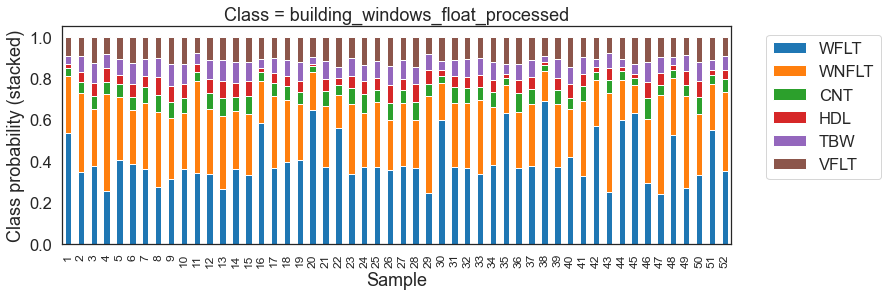

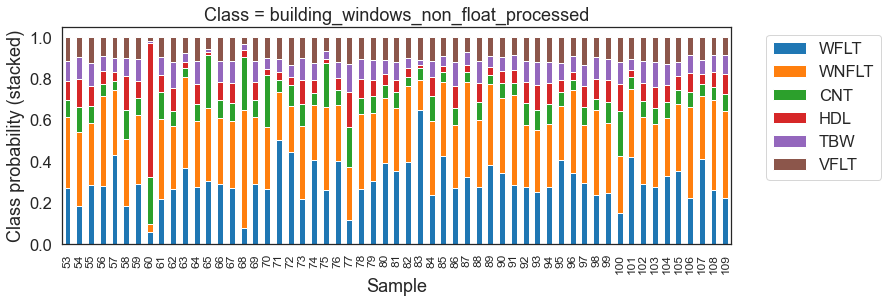

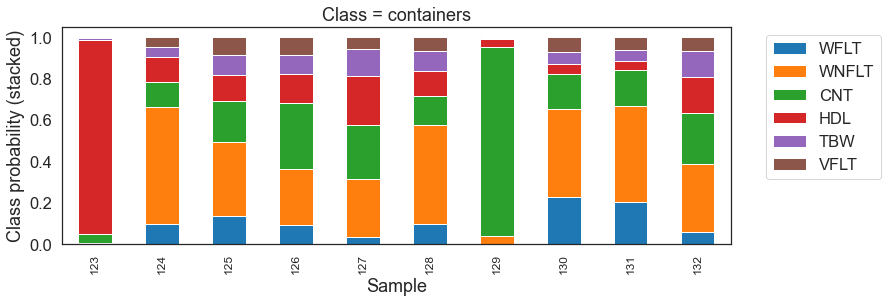

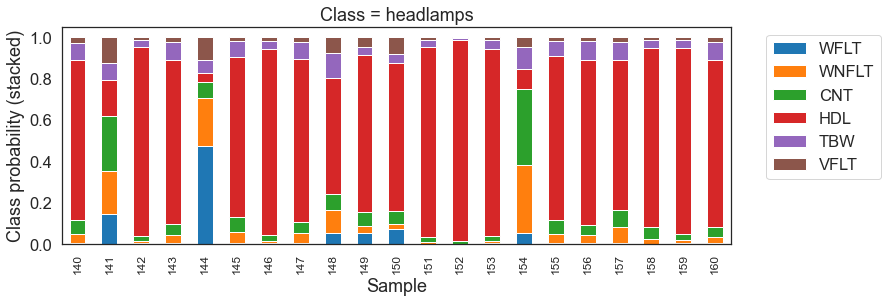

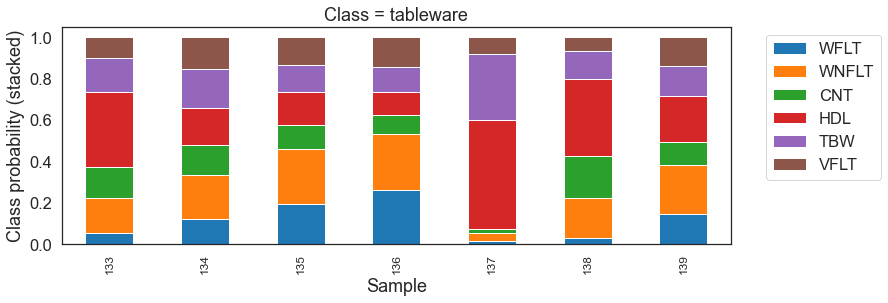

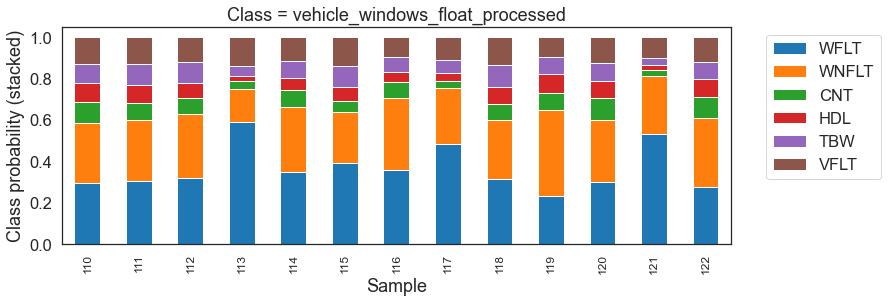

In [16]:
def plot_class(cls: str, df: pd.DataFrame):
    dfcls = df[y_test_raw == cls]
    dfcls.index.name = 'Sample'
    dfcls.plot(kind='bar', stacked=True, figsize=(12,4))
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.xticks(fontsize=12, rotation=90)
    plt.ylabel('Class probability (stacked)')
    plt.title(f'Class = {cls}')

for cls in CLASS_NAMES:
    plot_class(cls, dfprob)

# Deliverable 7 - repeat with a machine learning library

> _Implement the assignment using statistical or machine learning libraries in a language of your choice. Compare the results with those obtained above, and provide a discussion as to why you believe your results are different if you found them to be different._

In this section we repeat the experiments above using scikit-learn.

In [17]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

## Deliverable 7.1 - effect of lambda on coefficients

We selected the `sag` solver in this case to match the algorithm implemented in our code, so the classifiers are comparable. This solver requires a larger value of `max_iter` to converge.

In [18]:
betas_sk = []
for lmbda in LAMBDAS_TO_TEST:
    x, y, y_raw = read_dataset(TRAINING_DATASET, standardize=False)
    model_sk = pipeline.make_pipeline(preprocessing.StandardScaler(), 
        linear_model.LogisticRegression(multi_class='multinomial', 
            solver='sag', penalty='l2', C=1/lmbda,
            max_iter=6000, random_state=42))
    model_sk.fit(x, y_raw.ravel())
    # scikit returns coefficient in (classes, features)
    # Store its transpose to match our code, so we can plot later
    coef_sk = model_sk.named_steps['logisticregression'].coef_.T
    betas_sk.append(coef_sk)

Plots the results.

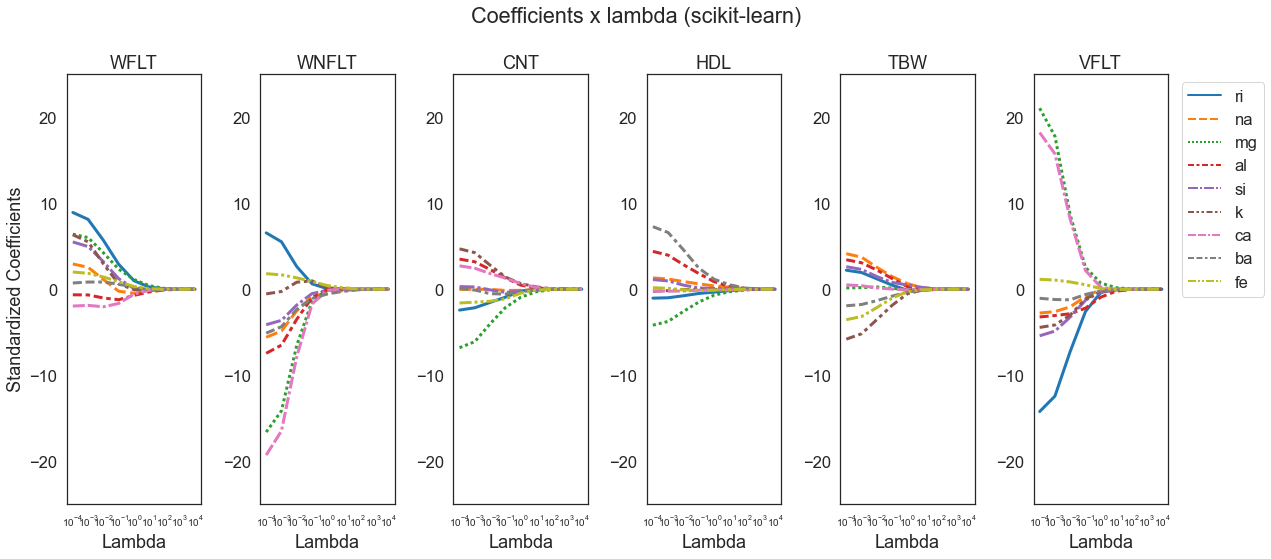

In [19]:
plot_betas(betas_sk, 'Coefficients x lambda (scikit-learn)', 25, -25)

For comparison, the plots below show the coefficient from our code. We can see that the coefficient values is much larger for scikit-learn. The relative value of the coefficient is similar, but not exactly the same. We can also see that the L2 regularization of the scikit-learn classifier is more aggressive. It decreases the coefficient values more rapidly than our code. This is likely a result of the dynamic learning rate calculation in scikit-learn. While our code uses a fixed learning rate, scikit- learn chooses a learning rate based on the regularization parameter.

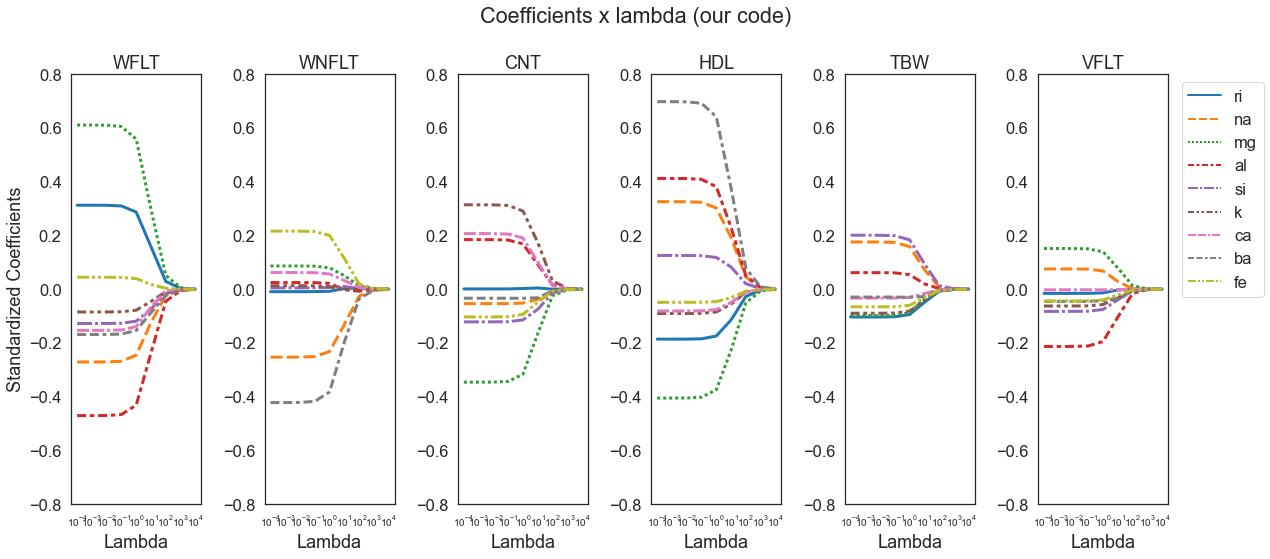

In [20]:
plot_betas(betas, 'Coefficients x lambda (our code)', 0.8, -0.8)

## Deliverable 7.2 - effect of lambda on cross-validation error (categorial cross-entropy)

To perform cross-validation with categorical cross-entropy in scikit-learn, we need to:

- Configure `LogistiRegressionCV`with `scoring=‘neg_log_loss’`: scikit-learn supports [multiple scoring methods](https://scikit-learn.org/stable/modules/model_evaluation.html). We pick this value to be consistent with our experiments.
- Take the negative of `neg_log_loss`. As the name implies, `neg_log_loss` is the negative of the cross-entropy loss. We need to take its negative to compare with our code.
- Read the loss values from the `scores_` model variable from any of the classes. According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html), _"If the ‘multi_class’ option given is ‘multinomial’ then the same scores are repeated across all classes,..."_. Therefore we can pick any class, since they all have the same coefficient values.

In [21]:
x, y, y_raw = read_dataset(TRAINING_DATASET, standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(), 
        linear_model.LogisticRegressionCV(multi_class='multinomial', 
            solver='sag', penalty='l2', 
            Cs=1/np.array(LAMBDAS_TO_TEST), cv=2, scoring='neg_log_loss',
            max_iter=5000, random_state=42))
p.fit(x, y_raw.ravel())
model_sk = p.named_steps['logisticregressioncv']

# Mean categorical cross-entropy for each fold
# We can pick any class when setting multi_class='multinomial'
cce_sk = model_sk.scores_[CLASS_NAMES[0]].mean(axis=0) * -1.0

Plot the results.

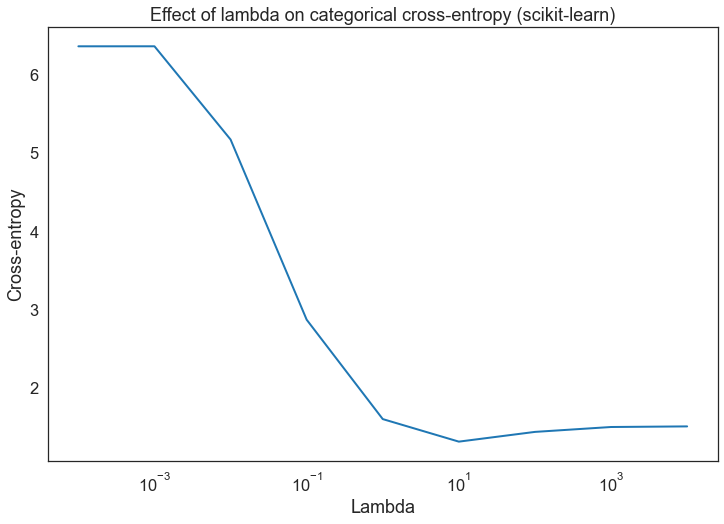

In [22]:
plot_cce(cce_sk.flatten(), 'Effect of lambda on categorical cross-entropy (scikit-learn)')

## Deliverable 7.3 - the lambda with the smallest cross-validation error

`LogisticRegressionCV` stores the best values of lambda for each class separately. Although each class could end up with a different lambda, in practice all classes usually have the same lambda, so we use the lambda from the first class.

We need one more adjustmen: scikit-learn's `C_` parameter is [_"...the inverse of regularization strength."_](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). To find the lambda value we need to invert that parameter.

In [23]:
# Although C_ could be different for each class, it's likely not
smallest_cce_lambda_sk = 1/model_sk.C_[0]
print(f'The lambda with the smallest categorical cross-entropy is {smallest_cce_lambda_sk}')

The lambda with the smallest categorical cross-entropy is 10.0


## Deliverable 7.4 - model parameters for the lambda with the smallest cross-validation error

Train a model with the lambda that has the smallest categorical cross-entropy.

In [24]:
x, y, y_raw = read_dataset(TRAINING_DATASET, standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(), 
        linear_model.LogisticRegression(multi_class='multinomial', 
            solver='sag', penalty='l2', C=1/smallest_cce_lambda_sk,
            max_iter=2000, random_state=42))
p.fit(x, y_raw.ravel())

model_sk = p.named_steps['logisticregression']
# scikit returns coefficient in (classes, features) order
# Transpose it to match our code (feature, classes), so we can plot later
coef_sk = model_sk.coef_.T

Predict the values on the test set.

In [25]:
x_test, y_test, y_test_raw = read_dataset(TEST_DATASET)
probabilities_sk = model_sk.predict_proba(x_test)
classes_sk = np.argmax(probabilities_sk, axis=1)

Show class probabilities and predicted ancestry, compared with the original class.

**Note**: scikit-learn also assigns the class Oceanian to individual four (see note in our code), with a high probability.

In [26]:
# Class names from class numbers
dfclass_sk = pd.DataFrame([model_sk.classes_[int(x)] for x in classes_sk], columns=['Predicted'])
dfclass_sk.index = np.arange(1, len(dfclass_sk) + 1)
# Probabilities for each class
dfprob_sk = pd.DataFrame(probabilities_sk, columns=CLASS_NAMES_SHORT)
dfprob_sk.index = np.arange(1, len(dfprob_sk) + 1)
# The actual labels from the test set
dfactual = pd.DataFrame(y_test_raw, columns=['Actual'])
dfactual.index = np.arange(1, len(dfactual) + 1)

# Combine them
dfcombined_sk = pd.concat([dfprob_sk, dfclass_sk, dfactual], axis=1)

dfcombined_sk

,WFLT,WNFLT,CNT,HDL,TBW,VFLT,Predicted,Actual
1,0.52,0.35,0.02,0.02,0.02,0.08,building_windows_float_processed,building_windows_float_processed
2,0.39,0.44,0.03,0.04,0.03,0.07,building_windows_non_float_processed,building_windows_float_processed
3,0.43,0.36,0.03,0.05,0.04,0.10,building_windows_float_processed,building_windows_float_processed
4,0.31,0.53,0.03,0.04,0.03,0.06,building_windows_non_float_processed,building_windows_float_processed
5,0.44,0.37,0.03,0.03,0.03,0.08,building_windows_float_processed,building_windows_float_processed
6,0.43,0.35,0.03,0.05,0.04,0.10,building_windows_float_processed,building_windows_float_processed
7,0.41,0.40,0.04,0.04,0.04,0.08,building_windows_float_processed,building_windows_float_processed
8,0.34,0.45,0.04,0.06,0.04,0.08,building_windows_non_float_processed,building_windows_float_processed
9,0.37,0.39,0.04,0.06,0.05,0.10,building_windows_non_float_processed,building_windows_float_processed
10,0.41,0.36,0.03,0.05,0.04,0.10,building_windows_float_processed,building_windows_float_processed


## Deliverable 7.5 - compare with expected real-world results

As it happened with our code, scikit-learn's logistic regression does not perform well on this dataset.

In [27]:
correct_labels = np.sum(dfclass_sk['Predicted'] == dfactual['Actual'])
print(f'Correct labels: {correct_labels} out of {dfactual.size}'
      f' ({correct_labels/dfactual.size:.2%} accurate)')

Correct labels: 97 out of 160 (60.62% accurate)


And again as we saw with our code, when splitting accuracy by class, it performs better in some classes. These are the classes with higher coefficients (refer to the graphs in deliverable 1).

In [28]:
for cls in CLASS_NAMES:
    dfoneclass = dfcombined_sk[dfcombined_sk['Actual'] == cls]
    correct_labels = np.sum(dfoneclass['Predicted'] == dfoneclass['Actual'])
    print(f'{cls:>38s}: {correct_labels:2d} out of {dfoneclass.shape[0]:2d}'
          f' ({correct_labels/dfoneclass.shape[0]:6.2%} accurate)')

      building_windows_float_processed: 35 out of 52 (67.31% accurate)
  building_windows_non_float_processed: 43 out of 57 (75.44% accurate)
                            containers:  1 out of 10 (10.00% accurate)
                             headlamps: 18 out of 21 (85.71% accurate)
                             tableware:  0 out of  7 ( 0.00% accurate)
       vehicle_windows_float_processed:  0 out of 13 ( 0.00% accurate)


The plots below show the probabilities assigned to each class.

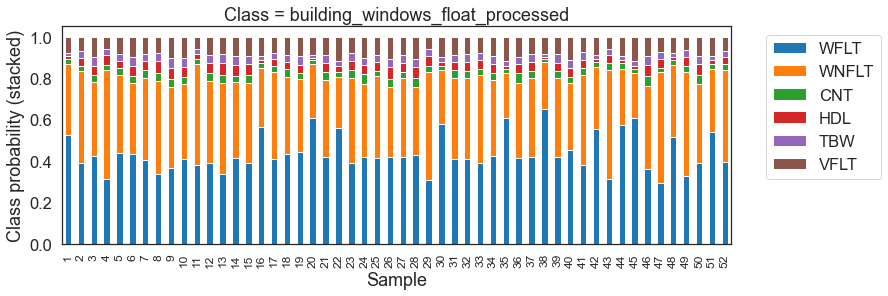

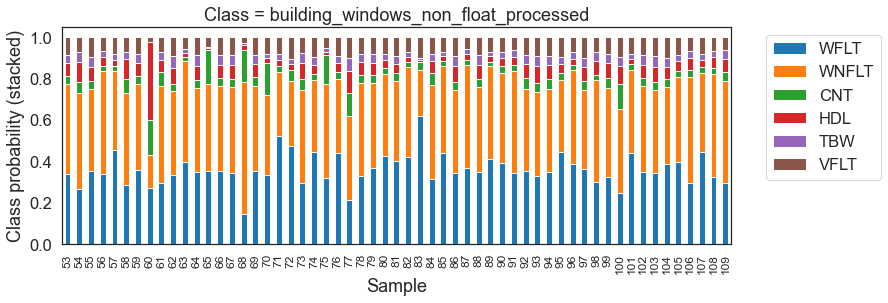

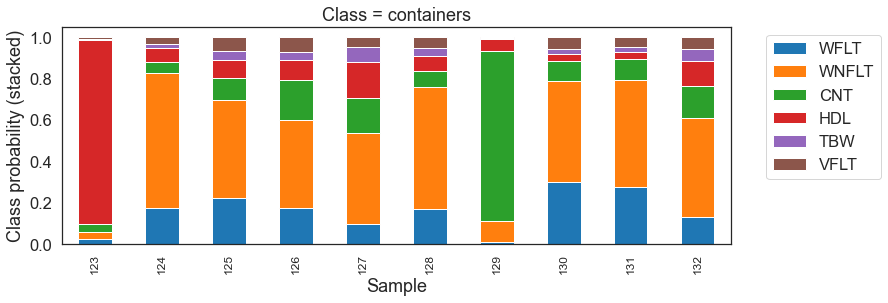

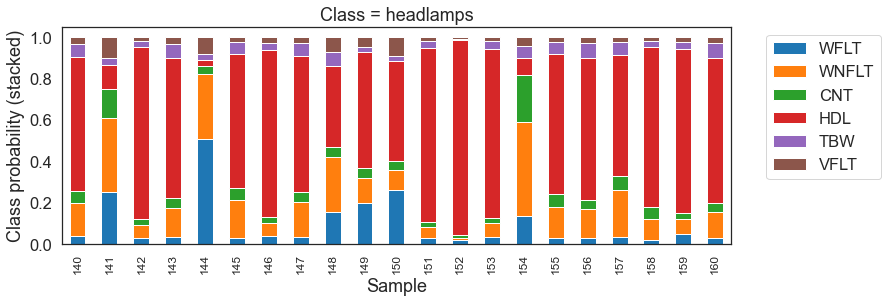

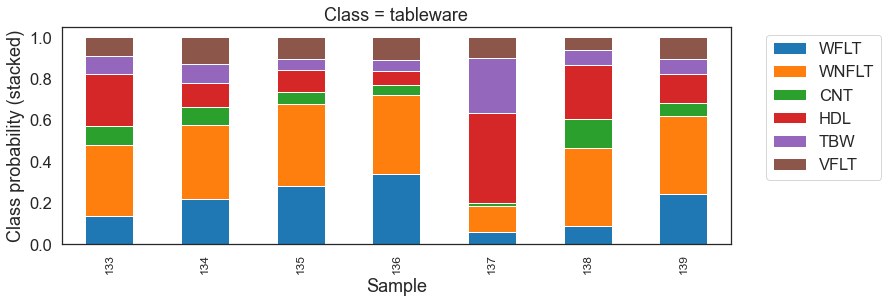

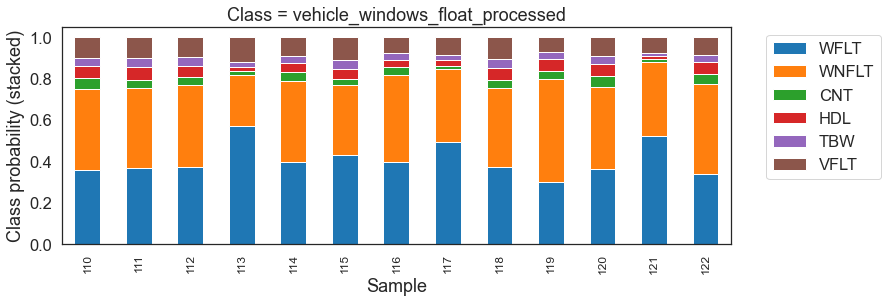

In [29]:
for cls in CLASS_NAMES:
    plot_class(cls, dfprob_sk)

## Discussion of differences

The scikit-learn `LogisticRegression` classifier and our code have similar overall accuracy and per-class accuracy. A few differences between them are:

1. Scikit-learn calculates the learning rate instead of letting the caller specify one. As a result, the coefficients decay towards zero more rapidly than our code, as shown in the graphs.
1. Scikit-learn uses the natural log instead of the base ten log for categorical cross-entropy. As a result, the scale of the "lambda vs. categorical cross-entropy" graph differs from our code.
1. Scikit-learn's class probabilities have a smaller spread than our code, as shown in the appendix below. This is likely the result of the cross-validation process in scikit-learn varying the lambda (provided by us) and the learning rate (calculated by scikit-learn) simultaneously. In the end, it is selecting from a different set of parameters, and the learning rate is the one likely making a difference).

As shown in the appendix, the classifiers agree on the class with the highest probability, but the scikit-learn classifier has a smaller spread across the classes, i.e. it is "more certain" about the prediction.

# Appendix

Extra pieces of information to inspect the results

## Features and class probabilities

The following table shows the features along with the class probablities calculated by our code for the first few samples in the test set.

In [30]:
dfpc = pd.DataFrame(x_test)
PC_NAMES = ['ri','na','mg','al','si','k','ca','ba','fe']
dfpc.columns = PC_NAMES

dfprob = pd.DataFrame(probabilities4, columns=CLASS_NAMES_SHORT)
dfclass = pd.DataFrame([CLASS_NAMES[int(x)] for x in classes4], columns=['Predicted'])
dfactual = pd.DataFrame(y_test_raw, columns=['Actual'])

dfpcprobs = pd.concat([dfpc, dfprob, dfclass, dfactual], axis=1)
dfpcprobs.index = np.arange(1, len(dfcombined) + 1)
dfpcprobs[:5]

,ri,na,mg,al,si,k,ca,ba,fe,WFLT,WNFLT,CNT,HDL,TBW,VFLT,Predicted,Actual
1,0.96,-0.36,0.66,-1.16,-0.41,-0.55,0.62,-0.33,1.01,0.54,0.27,0.04,0.02,0.04,0.09,building_windows_float_processed,building_windows_float_processed
2,-0.33,-0.59,0.60,-0.35,0.70,0.07,-0.43,-0.33,1.01,0.35,0.38,0.05,0.05,0.07,0.09,building_windows_non_float_processed,building_windows_float_processed
3,-0.35,-0.06,0.63,-0.61,0.55,0.14,-0.58,-0.33,-0.62,0.38,0.27,0.06,0.06,0.10,0.12,building_windows_float_processed,building_windows_float_processed
4,-0.82,-0.67,0.63,0.36,0.40,0.25,-0.65,-0.33,1.87,0.25,0.47,0.06,0.07,0.07,0.08,building_windows_non_float_processed,building_windows_float_processed
5,-0.22,-0.80,0.68,-0.57,0.58,0.19,-0.20,-0.33,-0.62,0.41,0.30,0.07,0.04,0.08,0.11,building_windows_float_processed,building_windows_float_processed


## Probabilities from our code and scikit-learn

The following table shows the probabilities calculated by our code (left half of the table) compared with the probabilities calculated by scikit-learn (right half of the table). In general, the spread of probabilties across the classes is slightly smaller for the scikit-learn classifier, i.e. it is "more certain" about the predictions.

In [31]:
df_ours_sk = pd.concat({'Our': dfcombined, 'scikit-learn': dfcombined_sk}, axis=1)
df_ours_sk[:20]

Our                                                                  \
   WFLT WNFLT  CNT  HDL  TBW VFLT                             Predicted   
1  0.54  0.27 0.04 0.02 0.04 0.09      building_windows_float_processed   
2  0.35  0.38 0.05 0.05 0.07 0.09  building_windows_non_float_processed   
3  0.38  0.27 0.06 0.06 0.10 0.12      building_windows_float_processed   
4  0.25  0.47 0.06 0.07 0.07 0.08  building_windows_non_float_processed   
5  0.41  0.30 0.07 0.04 0.08 0.11      building_windows_float_processed   
6  0.38  0.26 0.06 0.07 0.10 0.13      building_windows_float_processed   
7  0.36  0.32 0.08 0.06 0.08 0.11      building_windows_float_processed   
8  0.27  0.36 0.08 0.09 0.09 0.10  building_windows_non_float_processed   
9  0.31  0.30 0.08 0.08 0.10 0.13      building_windows_float_processed   
10 0.36  0.27 0.07 0.07 0.10 0.13      building_windows_float_processed   
11 0.34  0.44 0.05 0.04 0.05 0.08  building_windows_non_float_processed   
12 0.34  0.31 0.08 0.07 0.09 0.11      building_windows_float_processed   
13 0.27  0.35 0.09 0.08 0.10 0.11  building_windows_non_float_processed   
14 0.36  0.28 0.07 0.07 0.10 0.12      building_windows_float_processed   
15 0.33  0.30 0.09 0.07 0.09 0.12      building_windows_float_processed   
16 0.58  0.20 0.05 0.02 0.04 0.11      building_windows_float_processed   
17 0.37  0.35 0.06 0.05 0.07 0.10      building_windows_float_processed   
18 0.40  0.30 0.07 0.05 0.08 0.11      building_windows_float_processed   
19 0.40  0.27 0.06 0.05 0.09 0.12      building_windows_float_processed   
20 0.65  0.18 0.03 0.01 0.03 0.10      building_windows_float_processed   

                                     scikit-learn                            \
                              Actual         WFLT WNFLT  CNT  HDL  TBW VFLT   
1   building_windows_float_processed         0.52  0.35 0.02 0.02 0.02 0.08   
2   building_windows_float_processed         0.39  0.44 0.03 0.04 0.03 0.07   
3   building_windows_float_processed         0.43  0.36 0.03 0.05 0.04 0.10   
4   building_windows_float_processed         0.31  0.53 0.03 0.04 0.03 0.06   
5   building_windows_float_processed         0.44  0.37 0.03 0.03 0.03 0.08   
6   building_windows_float_processed         0.43  0.35 0.03 0.05 0.04 0.10   
7   building_windows_float_processed         0.41  0.40 0.04 0.04 0.04 0.08   
8   building_windows_float_processed         0.34  0.45 0.04 0.06 0.04 0.08   
9   building_windows_float_processed         0.37  0.39 0.04 0.06 0.05 0.10   
10  building_windows_float_processed         0.41  0.36 0.03 0.05 0.04 0.10   
11  building_windows_float_processed         0.38  0.49 0.02 0.03 0.02 0.06   
12  building_windows_float_processed         0.39  0.40 0.04 0.05 0.04 0.09   
13  building_windows_float_processed         0.34  0.44 0.04 0.06 0.04 0.08   
14  building_windows_float_processed         0.42  0.36 0.03 0.05 0.04 0.09   
15  building_windows_float_processed         0.39  0.38 0.04 0.05 0.04 0.09   
16  building_windows_float_processed         0.56  0.28 0.03 0.02 0.02 0.09   
17  building_windows_float_processed         0.41  0.42 0.03 0.03 0.03 0.08   
18  building_windows_float_processed         0.43  0.37 0.04 0.03 0.04 0.09   
19  building_windows_float_processed         0.44  0.35 0.03 0.04 0.04 0.09   
20  building_windows_float_processed         0.61  0.26 0.02 0.01 0.01 0.09   

                                                                            
                               Predicted                            Actual  
1       building_windows_float_processed  building_windows_float_processed  
2   building_windows_non_float_processed  building_windows_float_processed  
3       building_windows_float_processed  building_windows_float_processed  
4   building_windows_non_float_processed  building_windows_float_processed  
5       building_windows_float_processed  building_windows_float_processed  
6       building_windows_float_processed  building_windows_float_processed 